In [173]:
import copy
import pickle
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import IPython

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia


In [170]:
plt.rcParams.update({"font.size": 15})
rc("animation", html="html5")


In [3]:
path = Path.cwd()
fname = "R1 F3 detection.pkl"
data = {}


In [4]:
def get_diagonal_indices_flattened(size, states=None, mode="python"):
    if states is None:
        indices = [i + size * i for i in range(size)]
    else:
        indices = [i + size * i for i in states]
    if mode == "julia":
        return [i + 1 for i in indices]
    elif mode == "python":
        return indices


In [105]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=1, F1=5 / 2, F=3
    ),
    transitions.MicrowaveTransition(1, 2),
    transitions.MicrowaveTransition(2, 3),
]

# for some reason fails when using [couplings.polarization_Y, couplings.polarization_Z]
polarizations = [
    [couplings.polarization_Z],
    [couplings.polarization_X, couplings.polarization_Y],
    [couplings.polarization_Z, couplings.polarization_X],
]


transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)


In [111]:
v_to_Γ = utils.detuning.velocity_to_detuning(1)

odepars = lindblad_julia.odeParameters(
    # laser
    Ω0="Ωl0 * phase_modulation(t, β, ωphase)",
    Ωl0=1 * hamiltonian.Γ,  # Rabi frequency of the laser [rad/s]
    δ0=f"vx*{v_to_Γ}",  # detuning of the laser [rad/s]
    # laser phase modulation
    ωphase=hamiltonian.Γ,  # laser phase modulation frequency [rad/s]
    β=0,  # laser phase modulation depth [rad]
    PZ0=1,
    # microwave J=1 <-> J=2
    Ω1=1 * hamiltonian.Γ,
    P1="sin(ω1*t + ϕ1)",
    PX1="P1 >= 0",
    PY1="P1 < 0",
    ω1=1e6,
    φ1=0.0,
    δ1=0.0,
    # microwave J=2 <-> J=3
    Ω2=1 * hamiltonian.Γ,
    P2="sin(ω2*t + ϕ2)",
    # PZ2=1,
    PZ2="P2 >= 0",
    PX2="P2 < 0",
    ω2=1e6,
    φ2=0.0,
    δ2=0.0,
    # molecules
    z0=0,  # molecule start z position [m]
    vz=184,  # longitudinal molecular velocity [m/s]
    vx=0,
)


In [112]:
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=False,
    decay_channels=None,
    Jmax_X=4,
)


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [113]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 2, F₁ = 5/2, F = 3>"
states,
"|X, J = 1>",0.523531
"|X, J = 3>",0.476469


## Laser and J=1 microwave

In [114]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system, transition_selectors, odepars
)


In [115]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=1, electronic=states.ElectronicState.X), obe_system.QN
)

rabi_rates = np.linspace(0, 1, 22)[1:] * hamiltonian.Γ


In [129]:
# only save excited state populations

state_selector = states.QuantumSelector(electronic=states.ElectronicState.B)
indices = state_selector.get_indices(obe_system.QN)

save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), indices, mode="julia")

odepars.ωphase = 0.0
odepars.ω1 = 2 * np.pi * 1e6
odepars.ω2 = 2 * np.pi * 1e6
odepars.Ω1 = 0.0
odepars.Ω2 = 0.0


In [130]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()", save_idxs=save_idxs, saveat=1e-7, save_everystep=True
)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 5e-3 / odepars.vz))

scan_values = [rabi_rates, rabi_rates]
parameters = ["Ωl0", "Ω1"]

output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(nphotons=True)


ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)


In [131]:
results_laser_microwave12 = lindblad_julia.get_results_parameter_scan(
    scan=ensemble_problem
)


In [132]:
data["results_laser_microwave12"] = results_laser_microwave12
with open(path / fname, "wb") as filehandle:
    pickle.dump(data, filehandle)


In [133]:
res = copy.deepcopy(results_laser_microwave12)

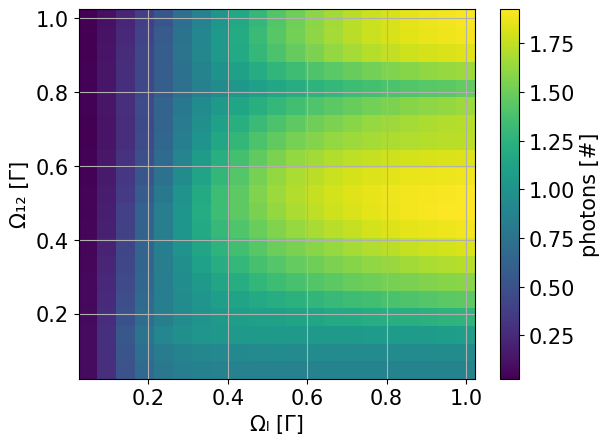

In [134]:
z = res.results
X, Y = np.asarray(res.scan_values) / hamiltonian.Γ

fig, ax = plt.subplots()
pmesh = ax.pcolormesh(X, Y, z)

cbar = fig.colorbar(pmesh)
cbar.ax.set_ylabel("photons [#]")

ax.set_xlabel("Ωₗ [Γ]")
ax.set_ylabel("Ω₁₂ [Γ]")
ax.grid(True)


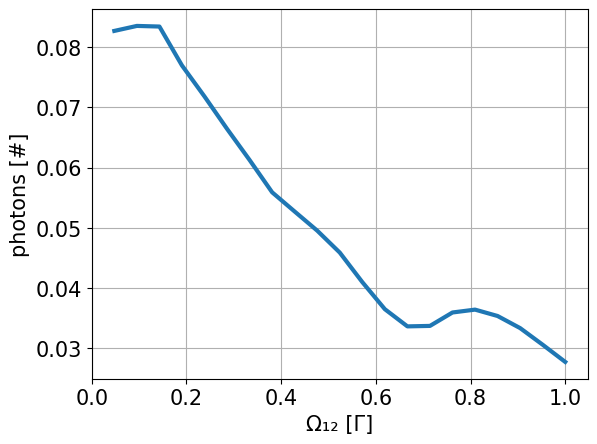

In [135]:
x = Y[0, :]
y = z[0, :]

fig, ax = plt.subplots()

ax.plot(x, y, lw=3)

ax.set_xlabel("Ω₁₂ [Γ]")
ax.set_ylabel("photons [#]")
ax.grid(True)


In [136]:
def pol(t: float, w: float, phase: float) -> float:
    return np.sin(w * t + phase) >= 0


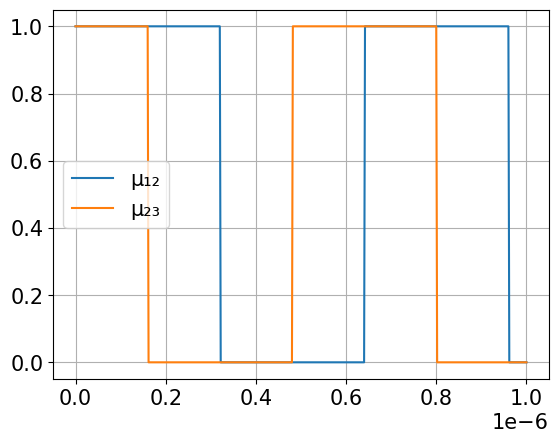

In [137]:
x = np.linspace(0, 1e-6, 501)

odepars.ω1 = hamiltonian.Γ
odepars.ω2 = hamiltonian.Γ
# resonant_switching uses cos, so have to add π/2
odepars.ϕ1 = 0
odepars.ϕ2 = np.pi / 2

p1 = pol(x, odepars.ω1, odepars.ϕ1)
p2 = pol(x, odepars.ω1, odepars.ϕ2)

odepars.ω1 = 0.0
odepars.ω2 = 0.0
odepars.ϕ1 = 0.0
odepars.ϕ2 = 0.0

fig, ax = plt.subplots()
# ax.plot(x, p0z < 0.5)
ax.plot(x, p1, label="μ₁₂")
ax.plot(x, p2, label="μ₂₃")
ax.legend()
ax.grid(True)


## J=1 and J=2 microwaves

In [146]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=1, electronic=states.ElectronicState.X), obe_system.QN
)

rabi_rates = np.linspace(0, 1, 12)[1:] * hamiltonian.Γ


In [147]:
# only save excited state populations

state_selector = states.QuantumSelector(electronic=states.ElectronicState.B)
indices = state_selector.get_indices(obe_system.QN)

save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), indices, mode="julia")

odepars.ωphase = 0.0
odepars.ω1 = 2 * np.pi * 1e6
odepars.ω2 = 2 * np.pi * 1e6
odepars.φ1 = 0.0
odepars.φ2 = np.pi / 2
odepars.Ω1 = 0.0
odepars.Ω2 = 0.0


In [148]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()", save_idxs=save_idxs, saveat=1e-7, save_everystep=True
)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 5e-3 / odepars.vz))

scan_values = [rabi_rates, rabi_rates, rabi_rates]
parameters = ["Ωl0", "Ω1", "Ω2"]

output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(nphotons=True)


ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)


In [149]:
results_microwaves = lindblad_julia.get_results_parameter_scan(scan=ensemble_problem)


In [150]:
data["results_microwaves"] = results_microwaves
with open(path / fname, "wb") as filehandle:
    pickle.dump(data, filehandle)


In [151]:
res = copy.deepcopy(results_microwaves)

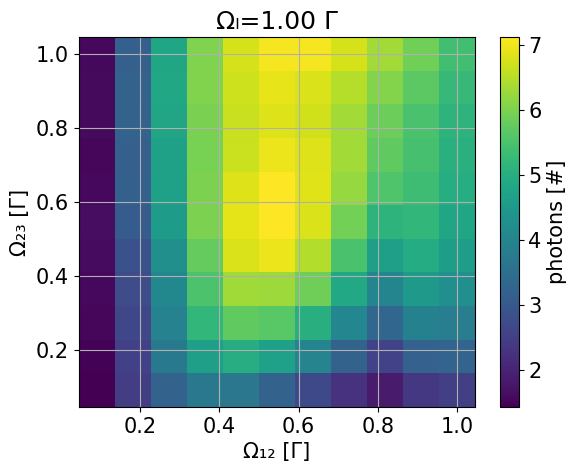

In [183]:
idr = -1

z = res.results[idr, :, :]

X, Y = (res.scan_values[1][idr, :, :], res.scan_values[2][idr, :, :])

fig, ax = plt.subplots()
pmesh = ax.pcolormesh(X / hamiltonian.Γ, Y / hamiltonian.Γ, z)

cbar = fig.colorbar(pmesh)
cbar.ax.set_ylabel("photons [#]")

ax.set_title(f"Ωₗ={res.scan_values[0][idr,0,0]/hamiltonian.Γ:.2f} Γ")
ax.set_xlabel("Ω₁₂ [Γ]")
ax.set_ylabel("Ω₂₃ [Γ]")
ax.grid(True)


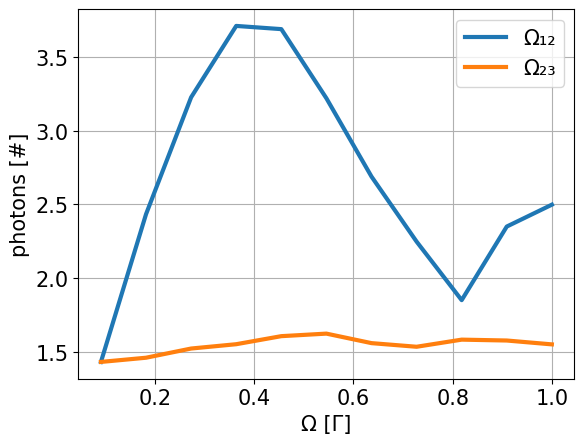

In [157]:
fig, ax = plt.subplots()

x = X[:, 0] / hamiltonian.Γ
y = z[:, 0]
ax.plot(x, y, lw=3, label="Ω₁₂")

x = Y[0, :] / hamiltonian.Γ
y = z[0, :]
ax.plot(x, y, lw=3, label="Ω₂₃")

ax.set_xlabel("Ω [Γ]")
ax.set_ylabel("photons [#]")
ax.legend()
ax.grid(True)


In [184]:
idr = -1

z = res.results[idr, :, :]

X, Y = (res.scan_values[1][idr, :, :], res.scan_values[2][idr, :, :])

fig, ax = plt.subplots()
pmesh = ax.pcolormesh(X / hamiltonian.Γ, Y / hamiltonian.Γ, z)

cbar = fig.colorbar(pmesh)
cbar.ax.set_ylabel("photons [#]")


ax.set_title(f"Ωₗ={res.scan_values[0][idr,0,0]/hamiltonian.Γ:.2f} Γ")
ax.set_xlabel("Ω₁₂ [Γ]")
ax.set_ylabel("Ω₂₃ [Γ]")
ax.grid(True)

fig.tight_layout()


def animate(
    i,
    ax,
    pmesh,
    data,
):
    ax.set_title(f"Ωₗ={data.scan_values[0][i,0,0]/hamiltonian.Γ:.2f} Γ")
    pmesh.update({"array": data.results[i]})
    return (pmesh,)


ani = animation.FuncAnimation(
    fig,
    animate,
    frames=res.results.shape[0],
    interval=500,
    blit=True,
    fargs=(
        ax,
        pmesh,
        res,
    ),
)

vid = ani.to_html5_video()

plt.close()

IPython.display.HTML(vid)


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 2.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 'C:\Users\ogras\AppData\Local\Temp\tmpc0xve28w\temp.m4v'


## Thermal Distribution

In [187]:
from typing import Sequence, Optional
import numpy.typing as npt
from centrex_tlf.utils.population import thermal_population, J_levels


def generate_thermal_population_states(
    temperature: float,
    QN: Sequence[states.State],
    select: Optional[states.QuantumSelector] = None,
) -> npt.NDArray[np.complex_]:
    levels = len(QN)
    ρ = np.zeros([levels, levels], dtype=complex)

    assert isinstance(QN[0], states.State), "no State objects supplies"

    if select is not None:
        j_levels = np.unique(select.J)
    else:
        j_levels = np.unique(
            [
                qn.largest.J
                for qn in QN
                if qn.largest.electronic_state == states.ElectronicState.X
            ]
        )

    # get the relative thermal population fractions of the ground state
    population = dict(
        [(j, p) for j, p in zip(j_levels, thermal_population(j_levels, temperature))]
    )

    for idx, qn in enumerate(QN):
        if qn.largest.electronic_state is not states.ElectronicState.X:
            continue
        elif qn.largest.F is None:
            ρ[idx, idx] = population[qn.largest.J]
        else:
            ρ[idx, idx] = population[qn.largest.J] / J_levels(qn.largest.J)

    return ρ


In [188]:
temperature = 6.3

ρ = generate_thermal_population_states(temperature=temperature, QN=obe_system.QN)


rabi_rates = np.linspace(0, 1, 12)[1:] * hamiltonian.Γ


In [199]:
# only save excited state populations

state_selector = states.QuantumSelector(electronic=states.ElectronicState.B)
indices = state_selector.get_indices(obe_system.QN)

save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), indices, mode="julia")

odepars.ωphase = 0.0
odepars.ω1 = 2 * np.pi * 1e6
odepars.ω2 = 2 * np.pi * 1e6
odepars.φ1 = 0.0
odepars.φ2 = np.pi / 2
odepars.Ω1 = 0.0
odepars.Ω2 = 0.0


In [200]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()", save_idxs=save_idxs, saveat=1e-7, save_everystep=True
)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 5e-3 / odepars.vz))

scan_values = [rabi_rates, rabi_rates, rabi_rates]
parameters = ["Ωl0", "Ω1", "Ω2"]

output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(nphotons=True)


ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)


In [201]:
results_thermal = lindblad_julia.get_results_parameter_scan(scan=ensemble_problem)


In [202]:
data["results_thermal"] = results_thermal
with open(path / fname, "wb") as filehandle:
    pickle.dump(data, filehandle)


In [203]:
res = copy.deepcopy(results_thermal)

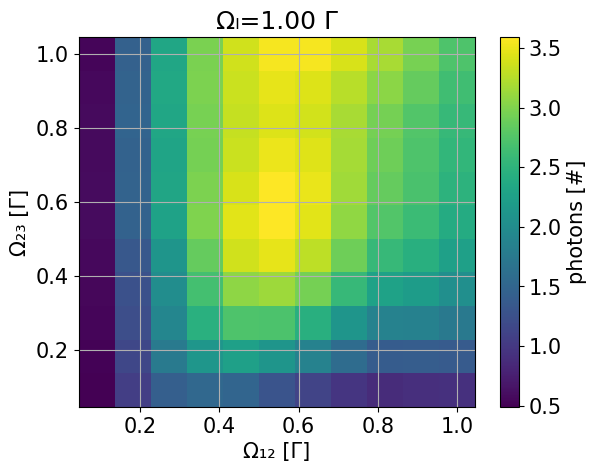

In [204]:
idr = -1

z = res.results[idr, :, :]

X, Y = (res.scan_values[1][idr, :, :], res.scan_values[2][idr, :, :])

fig, ax = plt.subplots()
pmesh = ax.pcolormesh(X / hamiltonian.Γ, Y / hamiltonian.Γ, z)

cbar = fig.colorbar(pmesh)
cbar.ax.set_ylabel("photons [#]")

ax.set_title(f"Ωₗ={res.scan_values[0][idr,0,0]/hamiltonian.Γ:.2f} Γ")
ax.set_xlabel("Ω₁₂ [Γ]")
ax.set_ylabel("Ω₂₃ [Γ]")
ax.grid(True)


In [205]:
idr = -1

z = res.results[idr, :, :]

X, Y = (res.scan_values[1][idr, :, :], res.scan_values[2][idr, :, :])

fig, ax = plt.subplots()
pmesh = ax.pcolormesh(X / hamiltonian.Γ, Y / hamiltonian.Γ, z)

cbar = fig.colorbar(pmesh)
cbar.ax.set_ylabel("photons [#]")


ax.set_title(f"Ωₗ={res.scan_values[0][idr,0,0]/hamiltonian.Γ:.2f} Γ")
ax.set_xlabel("Ω₁₂ [Γ]")
ax.set_ylabel("Ω₂₃ [Γ]")
ax.grid(True)

fig.tight_layout()


def animate(
    i,
    ax,
    pmesh,
    data,
):
    ax.set_title(f"Ωₗ={data.scan_values[0][i,0,0]/hamiltonian.Γ:.2f} Γ")
    pmesh.update({"array": data.results[i]})
    return (pmesh,)


ani = animation.FuncAnimation(
    fig,
    animate,
    frames=res.results.shape[0],
    interval=500,
    blit=True,
    fargs=(
        ax,
        pmesh,
        res,
    ),
)

vid = ani.to_html5_video()

plt.close()

IPython.display.HTML(vid)


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 2.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 'C:\Users\ogras\AppData\Local\Temp\tmpq32q2pl1\temp.m4v'


## Cooling Distribution

In [215]:
ρ = generate_thermal_population_states(temperature=temperature, QN=obe_system.QN)

cooling_efficiency = 0.8

ρ *= 1 - cooling_efficiency


In [216]:
# only save excited state populations

state_selector = states.QuantumSelector(electronic=states.ElectronicState.B)
indices = state_selector.get_indices(obe_system.QN)

save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), indices, mode="julia")

odepars.ωphase = 0.0
odepars.ω1 = 2 * np.pi * 1e6
odepars.ω2 = 2 * np.pi * 1e6
odepars.φ1 = 0.0
odepars.φ2 = np.pi / 2
odepars.Ω1 = 0.0
odepars.Ω2 = 0.0


In [217]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()", save_idxs=save_idxs, saveat=1e-7, save_everystep=True
)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 5e-3 / odepars.vz))

scan_values = [rabi_rates, rabi_rates, rabi_rates]
parameters = ["Ωl0", "Ω1", "Ω2"]

output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(nphotons=True)


ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)


In [218]:
results_cooling = lindblad_julia.get_results_parameter_scan(scan=ensemble_problem)


In [219]:
data["results_cooling"] = results_cooling
with open(path / fname, "wb") as filehandle:
    pickle.dump(data, filehandle)


In [220]:
res = copy.deepcopy(results_cooling)

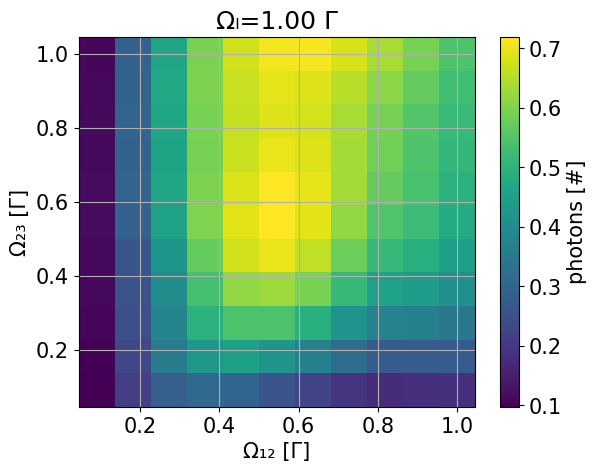

In [221]:
idr = -1

z = res.results[idr, :, :]

X, Y = (res.scan_values[1][idr, :, :], res.scan_values[2][idr, :, :])

fig, ax = plt.subplots()
pmesh = ax.pcolormesh(X / hamiltonian.Γ, Y / hamiltonian.Γ, z)

cbar = fig.colorbar(pmesh)
cbar.ax.set_ylabel("photons [#]")

ax.set_title(f"Ωₗ={res.scan_values[0][idr,0,0]/hamiltonian.Γ:.2f} Γ")
ax.set_xlabel("Ω₁₂ [Γ]")
ax.set_ylabel("Ω₂₃ [Γ]")
ax.grid(True)


In [222]:
idr = -1

z = res.results[idr, :, :]

X, Y = (res.scan_values[1][idr, :, :], res.scan_values[2][idr, :, :])

fig, ax = plt.subplots()
pmesh = ax.pcolormesh(X / hamiltonian.Γ, Y / hamiltonian.Γ, z)

cbar = fig.colorbar(pmesh)
cbar.ax.set_ylabel("photons [#]")


ax.set_title(f"Ωₗ={res.scan_values[0][idr,0,0]/hamiltonian.Γ:.2f} Γ")
ax.set_xlabel("Ω₁₂ [Γ]")
ax.set_ylabel("Ω₂₃ [Γ]")
ax.grid(True)

fig.tight_layout()


def animate(
    i,
    ax,
    pmesh,
    data,
):
    ax.set_title(f"Ωₗ={data.scan_values[0][i,0,0]/hamiltonian.Γ:.2f} Γ")
    pmesh.update({"array": data.results[i]})
    return (pmesh,)


ani = animation.FuncAnimation(
    fig,
    animate,
    frames=res.results.shape[0],
    interval=500,
    blit=True,
    fargs=(
        ax,
        pmesh,
        res,
    ),
)

vid = ani.to_html5_video()

plt.close()

IPython.display.HTML(vid)


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 2.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 'C:\Users\ogras\AppData\Local\Temp\tmp3l3ury70\temp.m4v'


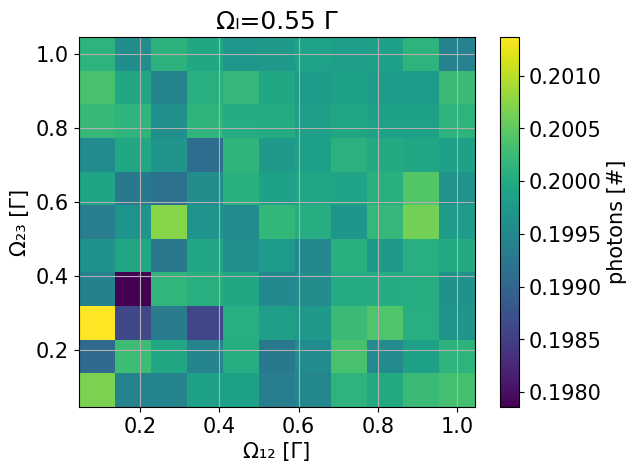

In [225]:
results_cooling

idr = 5

z = results_cooling.results[idr, :, :] / results_thermal.results[idr, :, :]

X, Y = (res.scan_values[1][idr, :, :], res.scan_values[2][idr, :, :])

fig, ax = plt.subplots()
pmesh = ax.pcolormesh(X / hamiltonian.Γ, Y / hamiltonian.Γ, z)

cbar = fig.colorbar(pmesh)
cbar.ax.set_ylabel("photons [#]")

ax.set_title(f"Ωₗ={res.scan_values[0][idr,0,0]/hamiltonian.Γ:.2f} Γ")
ax.set_xlabel("Ω₁₂ [Γ]")
ax.set_ylabel("Ω₂₃ [Γ]")
ax.grid(True)


In [229]:
idr = -1

z = results_cooling.results[idr] / results_thermal.results[idr]

X, Y = (res.scan_values[1][idr, :, :], res.scan_values[2][idr, :, :])

fig, ax = plt.subplots()
pmesh = ax.pcolormesh(
    X / hamiltonian.Γ, Y / hamiltonian.Γ, z, vmin=z.min(), vmax=z.max()
)

cbar = fig.colorbar(pmesh)
cbar.ax.set_ylabel("photons [#]")


ax.set_title(f"Ωₗ={res.scan_values[0][idr,0,0]/hamiltonian.Γ:.2f} Γ")
ax.set_xlabel("Ω₁₂ [Γ]")
ax.set_ylabel("Ω₂₃ [Γ]")
ax.grid(True)

fig.tight_layout()


def animate(
    i,
    ax,
    pmesh,
    scan_values,
    data,
):
    ax.set_title(f"Ωₗ={scan_values[0][i,0,0]/hamiltonian.Γ:.2f} Γ")
    pmesh.update({"array": data[i]})
    return (pmesh,)


ani = animation.FuncAnimation(
    fig,
    animate,
    frames=res.results.shape[0],
    interval=500,
    blit=True,
    fargs=(
        ax,
        pmesh,
        results_cooling.scan_values,
        results_cooling.results / results_thermal.results,
    ),
)

vid = ani.to_html5_video()

plt.close()

IPython.display.HTML(vid)


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 2.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 'C:\Users\ogras\AppData\Local\Temp\tmp1ef8whrr\temp.m4v'
